In [1]:

import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib



In [2]:
import pickle
from scatteringTables import *
d=pickle.load(open('iwcCoeff.pkl','rb'))
iwcCoeff=d['iwcCoeff']
peak=d['peak']
iwcCoeff_SSRG=np.polyfit(zST[2,:],np.log10(iwcST[2,:]),1)


In [3]:
# these coefficients are used to parameterize the variation of Nw as a function of height
# they are not used in this simplified example
dnCoeff=np.array([0.01975583*2.5, 0.22])
dn1D=np.polyval(dnCoeff,range(50))


In [4]:
# this section reads environmental data and defines a wrapper function for the lidar simulator
# the following reads the gaseous extinction (at the radiometer's frequencies) from the file kext_atm_allChannels.nc
with nc.Dataset('kext_atm_allChannels.nc','r') as f:
    kext_atm=f.variables['kext_atm'][:]
    kext_atm=np.array(kext_atm)

# this reads the profiles of temperature, pressure, water vapor and liquid water content from the file profiles.nc
with nc.Dataset('profiles.nc','r') as f:
    qv=f.variables['qv'][:]
    press=f.variables['press'][:]
    temp=f.variables['temp'][:]
    tempm=f.variables['tempm'][:]
    pressf=f.variables['pressf'][:]
    rho=f.variables['rho'][:]

kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(4)]

npart=4
undef=0.0
nrefl=2
ice_type=1

# before running the following, build the lidar simulator
# cd  src_fort
# gfortran -c -fPIC band_dble.f90 
# cd ..
# f2py -c -m lidarSim src_fort/lidar_simulator.F90 src_fort/bisection.f90 src_fort/radtran_tau_dble.f src_fort/rosen.f src_fort/band_dble.o 
import lidarSim as lidar
def get_pnorm(nz,dr,temp1,pres1,presf1,qv1,iwc1,rho1,dm_ice):
    h1=dr/2+np.arange(nz)*dr
    h1f=np.arange(nz)*dr
    q_lsice1=iwc1/rho1*1e-3
    q_lsice=q_lsice1[np.newaxis,:]
    pres1=pres1[np.newaxis,:]
    presf1=presf1[np.newaxis,:]
    temp1=temp1[np.newaxis,:]
    q_lsliq=np.zeros((1,nz),float)
    ls_radice=dm_ice/2*1e-3
    ls_radice=ls_radice[np.newaxis,:]
    ls_radliq=np.zeros((1,nz),float)
    q_cvice=np.zeros((1,nz),float)
    cv_radice=np.zeros((1,nz),float)
    q_cvliq=np.zeros((1,nz),float)
    cv_radliq=np.zeros((1,nz),float)
    temp=temp1
    pres=pres1
    presf=presf1
    pmol,pnorm,pnorm_perp_tot,\
        tautot,betatot_liq,\
        betatot_ice,\
        betatot,refl, \
        zheight,\
        beta_mol, tau_mol,\
        alpha= lidar.lidar_simulator(npart,nrefl,undef,\
                                     pres1,presf1,\
                                     temp1,
                                     q_lsliq,q_lsice,\
                                     q_cvliq,\
                                     q_cvice,\
                                     ls_radliq,\
                                     ls_radice,\
                                     cv_radliq,cv_radice,\
                                     ice_type)
    return pmol,pnorm


In [5]:
# this module reads the cloudsat data and selects profiles meeting the criteria described in Grecu and Yorks (2023)
from csIO import *
import numpy as np
import matplotlib.pyplot as plt

def process(dbz,cpr_cmask,temp,iwc,re,height,iwp):
    a=np.nonzero(np.array(iwp)>0)
    b=np.nonzero(temp[a].max(axis=1)>280)
    a=a[0][b]
    temp0L=[]
    isfcPrecip=0
    iwp1L=[]
    iwp2L=[]
    iwcL=[]
    reL=[]
    zwL=[]
    iL=[]
    dbzL=[]
    ikL=[]
    hL=[]
    for i in a[0:]:
        b1=np.nonzero(temp[i]<273.15)
        ik=b1[0][-1]
        nprecip1=np.nonzero(cpr_cmask[i,ik:100]>30)
        temp0L.append(ik)
        if(len(nprecip1[0])>3):
            isfcPrecip+=1
            dbz[i,:]=-99
        else:
            if ik+3-40>0:
                iwp1L.append(iwp[i])
                iwp2L.append(iwc[i,ik+3-50:ik+3].data.sum()*0.24)
                iwcL.append(iwc[i,:])
                reL.append(re[i,:])
                zwL.append(dbz[i,ik+3-50:ik+3])
                iL.append(i)
                dbzL.append(dbz[i,:])
                ikL.append(ik)
                hL.append(height[i,ik+3])
    return iwp1L,iwp2L,zwL,iwcL,reL,iL,dbzL,ikL,hL

fs=sorted(glob.glob("sampleData/2019*2C*hdf"))
fs_2B=sorted(glob.glob("sampleData/2019*2B*hdf"))
import xarray as xr
for i,f in enumerate(fs[:1]):
    iwc,dbz_sim,temp2C,re,height,lonC,latC,iwp=read2C_ICE(f)
    fh=Dataset(fs_2B[i])
    dbz=fh['Radar_Reflectivity'][:]/100.
    cpr_cmask=fh['CPR_Cloud_mask'][:]
    iwp1L,iwp2L,zwL,iwcL,reL,iL,dbzL,ikL,hL_2C=process(dbz,cpr_cmask,temp2C,iwc,re,height,iwp)
    break
print(f,fs_2B[i])


sampleData/2019151234028_69732_CS_2C-ICE_GRANULE_P1_R05_E08_F03.hdf sampleData/2019151234028_69732_CS_2B-GEOPROF_GRANULE_P1_R05_E08_F03.hdf


In [16]:
import lidarSim as lidSim
fisot=2.7
umu=np.cos(np.deg2rad(53.0))
nt1,nz=qv.shape
height=np.arange(nz+1)*0.240
nt=len(dbzL)
dbzL=np.array(dbzL)
iwcL=np.array(iwcL)
iwc_SSRG=np.zeros((nt,50),float)
dm_SSRG=np.zeros((nt,50),float)

zkuCoeff=np.polyfit(zST[2,:30],(zST[0,:30]),1)
dmCoeff=np.polyfit(zST[2,:],np.log10(dmST[2,:]),1)
zwCoeff=np.polyfit(np.log10(iwcST[2,:30]),zST[2,:30],1)
iwcLowCoeff=np.polyfit(zST[2,:200],np.log10(iwcST[2,:200]),1)
kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(5)]

tbL=[]
epsL=[]
zKu=np.zeros((nt,50),float)-99.9
zKuL=[]
pnormL=[]
dm_SSRGL=[]
dnL=[]
ifreqC=[0,1,2,3,3,3,3,3,3,4,4,4]
from scipy.ndimage import gaussian_filter1d
zcfad=np.zeros((42,50),float)
zwcfad=np.zeros((42,50),float)
bcfad=np.zeros((40,50),float)
bcfad2=np.zeros((50,50),float)
pmolL=[]
for i in range(0,900):
    i1=i
    zw1=dbzL[i1,ikL[i1]-60+3:ikL[i1]+3][::-1]
    iwc1D=iwcL[i1,ikL[i1]-60+3:ikL[i1]+3][::-1]
    a1=np.nonzero(iwc1D>0)
    kextI=np.zeros((50,12),float)
    salbI=np.zeros((50,12),float)
    asymI=np.zeros((50,12),float)
    ic=np.random.randint(0,30)
    kext1D=kext_atm[ic,:,:].copy()
    salb1D=np.zeros((64,12),float)
    asym1D=np.zeros((64,12),float)
    dnp=np.random.randn(64)
    dnp=gaussian_filter1d(dnp,2)
    dn1Dp=dnp
    iwcsum=iwc1D.sum()
    for k in a1[0]:
        zw11=zw1[k]
        dn1Dp[k]+=1
        if(zw1[k]-10*(dn1Dp[k])>=zST[2,0]):
            ifind = lidSim.bisection2(zST[2,:],zw1[k]-10*(dn1Dp[k]))
            dz=zST[2,ifind+1]-zST[2,ifind]
            w1=(zw11-10.*dn1Dp[k]-zST[2,ifind])/dz
            zKu[i,k]=zST[0,ifind]*w1+zST[0,ifind+1]*(1-w1)+10*dn1Dp[k]
            iwc_SSRG[i,k]=(iwcST[2,ifind]*w1+iwcST[2,ifind+1]*(1-w1))*10**dn1Dp[k]
            dm_SSRG[i,k]=(dmST[2,ifind]*w1+dmST[2,ifind+1]*(1-w1))
            for ifreq in range(12):
                ifreq1=ifreqC[ifreq]
                kextI[k,ifreq]=kextST[ifreq1,ifind]*10**(dn1Dp[k])
                salbI[k,ifreq]=kscaST[ifreq1,ifind]*10**(dn1Dp[k])
                asymI[k,ifreq]=gST[ifreq1,ifind]
        else:
            continue
            # when zw1[k]-10*(dn1Dp[k])<zST[2,0] the scattering properties can be
            # extrapolated using power low fits
            # as using the values at the lowest level results in artifacts
            # this is not illustrated in this simplified example 
    nz=50
    dr=0.240
    temp1=temp[ic,14:64]
    pres1=press[ic,14:64]
    presf1=pressf[ic,14:65]
    qv1=qv[ic,14:64]
    iwc1=iwc_SSRG[i,:]
    rho1=pres1/(287.05*temp1)
    dm_ice=dm_SSRG[i,:]
    dnL.append(dn1Dp.copy())
    pmol,pnorm=get_pnorm(nz,dr,temp1,pres1,presf1,qv1,iwc1,rho1,dm_ice)
    
    kext1D[14:64,:]+=kextI[:,:]
    salb1D[14:64,:]=salbI[:,:]
    asym1D[14:64,:]=asymI[:,:]
    salb1D/=kext1D
    emis=0.8+np.random.random()*0.2
    ebar=emis
    tb1=[]
    for ik in range(2,12):
        tbout = lidSim.radtran(umu,temp[ic][0],temp[ic],height,kext1D[:,ik],salb1D[:,ik],asym1D[:,ik],fisot,emis,ebar)
        tb1.append(tbout)
        if tbout!=tbout:
            stop
    tbL.append(tb1)
    zKuL.append(zKu[i,:])
    epsL.append(emis)
    dm_SSRGL.append(dm_ice)
    pnormL.append(pnorm[0,:])
    pmolL.append(pmol[0,:])
    


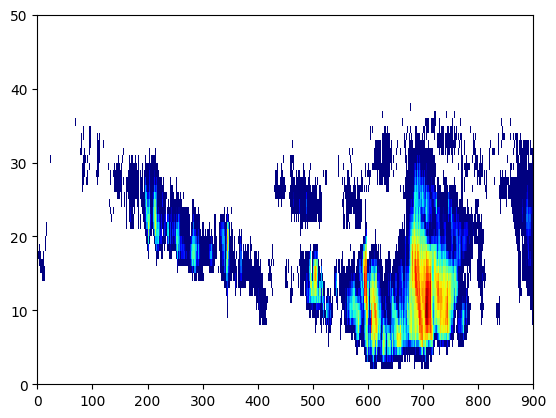

In [17]:
iwc_SSRGm=np.ma.array(iwc_SSRG,mask=iwc_SSRG<1e-3)
plt.pcolormesh(iwc_SSRGm[:900,:].T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-2,vmax=5e-1))

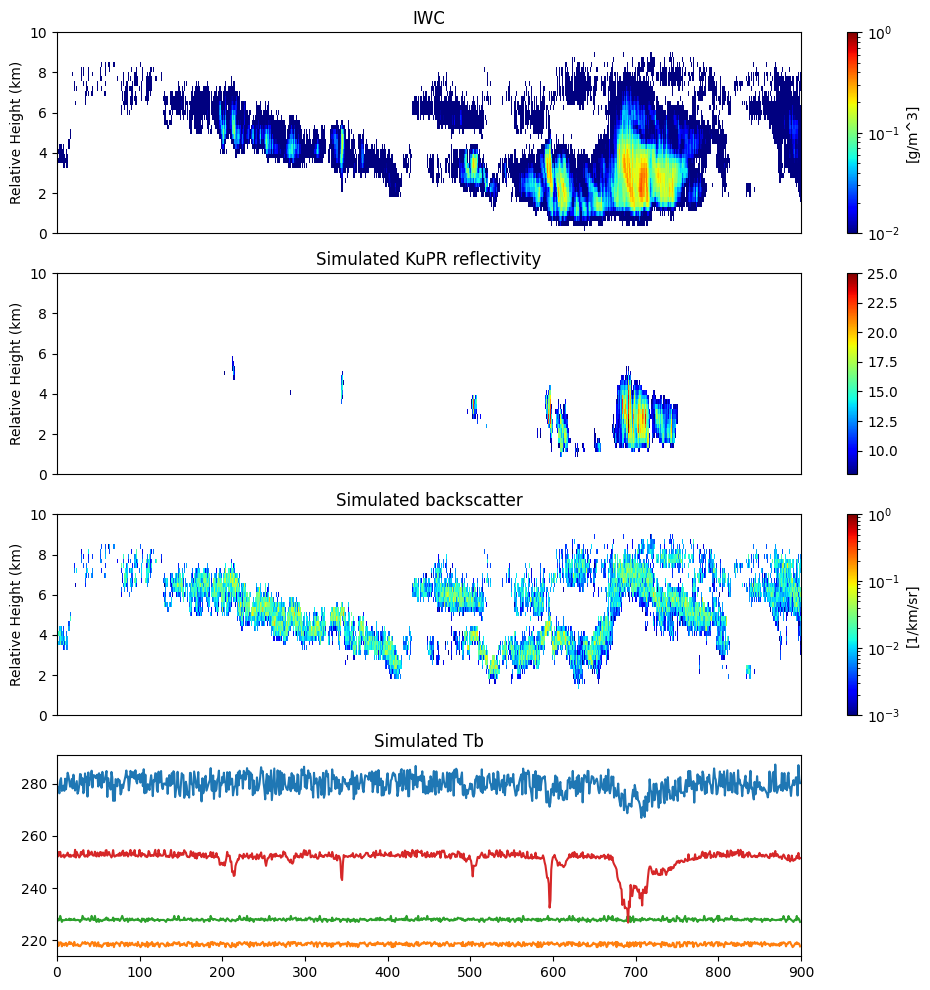

In [18]:
tbL=np.array(tbL)
pnormL=np.array(pnormL)
ss=np.shape(pnormL)
zKuL=np.array(zKuL)
zKuLm=np.ma.array(zKuL,mask=zKuL<8)
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
ax2=plt.subplot(4,1,2)
im1=plt.pcolormesh(np.arange(900),np.arange(50)*0.24,zKuLm[:900,:].T,cmap='jet',vmin=8,vmax=25)
plt.title('Simulated KuPR reflectivity')
ax2.xaxis.set_visible(False)
#plt.contour(np.arange(900),np.arange(50)*0.24,zKuL[:900,:].T,levels=[-10],linestyle='--',colors='k')
plt.ylim(0,10)
plt.ylabel('Relative Height (km)')
cbar=plt.colorbar(im1,orientation='vertical')
#cbar.ax.set_ylabel('[1/km/sr]')
ax3=plt.subplot(4,1,3)
pnormLm=np.ma.array(pnormL,mask=pnormL<2e-6)
plt.pcolormesh(np.arange(900),np.arange(50)*0.24,1e3*pnormLm.T*np.exp(0.5*np.random.randn(ss[1],ss[0])),cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=1e-0))
ax3.xaxis.set_visible(False)
plt.ylim(0,10)
plt.title('Simulated backscatter')
plt.xlabel('Scan number')
plt.ylabel('Relative Height (km)')
cbar=plt.colorbar(orientation='vertical')
# add labels to the colorbar
cbar.ax.set_ylabel('[1/km/sr]')
ax1=plt.subplot(4,1,1)
#plt.pcolormesh(np.array(iwcL)[0:900,::-1].T,cmap='jet')
iwc2C_ICE=[iwcL[i1,ikL[i1]-60+3:ikL[i1]+3][::-1] for i1 in range(900)]
iwc2C_ICE=np.array(iwc_SSRG[:,::-1])
iwcLm=np.ma.array(iwc_SSRG,mask=iwc_SSRG<1e-6)
plt.pcolormesh(np.arange(900),np.arange(50)*0.24,iwcLm[:900,:].T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-2,vmax=1e-0))
plt.ylim(0,10)
ax1.xaxis.set_visible(False)
plt.ylabel('Relative Height (km)')
cbar=plt.colorbar(orientation='vertical')
cbar.ax.set_ylabel('[g/m^3]')
plt.title('IWC')

ax0=plt.subplot(4,1,4)
plt.plot(np.arange(900),tbL[:,0])
plt.plot(np.arange(900),tbL[:,1])
plt.plot(np.arange(900),tbL[:,2])
plt.plot(np.arange(900),tbL[:,-1])
plt.title('Simulated Tb')
b1=ax1.get_position(original=False)
b0=ax0.get_position(original=False)
plt.xlim(0,900)
ax0.set_position([b0.x0,b0.y0,b1.width,b1.height])
plt.savefig('sim_AOS_Inclinded.png')


In [9]:
import xarray as xr
nt=len(zKuL)

# save the data in netcdf format
ds=xr.Dataset({'tb':(['time','chan'],tbL[0:nt,:]),
                'zKu':(['time','height'],zKuL),
                'pnorm':(['time','height'],1e3*np.array(pnormL)),
                'iwc_SSRG':(['time','height'],iwc_SSRG[0:nt,:]),
                'eps':(['time'],epsL),
                'dm_SSRG':(['time','height'],dm_SSRGL[0:nt]),
                'pmol':(['time','height'],1e3*np.array(pmolL))},
                coords={'time':np.arange(len(tbL[0:nt,:])),
                        'chan':np.arange(10),
                        'height':np.arange(50)})

ds.to_netcdf('simObsCrossTrack.nc',format='NETCDF4',encoding={'tb':{'zlib':True,'complevel':5},\
    'zKu':{'zlib':True,'complevel':5},'iwc_SSRG':{'zlib':True,'complevel':5},\
        'pnorm':{'zlib':True,'complevel':5},'dm_SSRG': {'zlib': True, 'complevel': 9},\
        'eps':{'zlib':True,'complevel':5},'pmol':{'zlib':True,'complevel':5}})  

